In [1]:
from importlib import reload  # Not needed in Python 2
import warnings
from datetime import datetime
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR
import sys
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm, trange
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import gc
import glob
import torch
from torch.utils.data import Dataset, DataLoader,RandomSampler, SequentialSampler
from sklearn.utils.class_weight import compute_class_weight
import warnings
from transformers import get_linear_schedule_with_warmup
from copy import deepcopy
import transformers
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix,f1_score, accuracy_score,precision_score, recall_score
from transformers import RobertaTokenizer, RobertaForMaskedLM
import torch

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit,GroupKFold
from transformers import PreTrainedModel,RobertaConfig,RobertaModel
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel,AutoConfig
from transformers import DataCollatorWithPadding,get_linear_schedule_with_warmup


def seed_all(seed_value):
    np.random.seed(seed_value) 
    torch.manual_seed(seed_value) 
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True  
        torch.backends.cudnn.benchmark = False  
        
RANDOM_SEED=106
seed_all(RANDOM_SEED)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_LABEL=4
L = False
DEBUG = False
EPOCHS=2
EVALAFTER=1000
PSEUDO=True
reinit_n_layers=3
PLAIN=False

MAX_LEN=400

BATCH_SIZE=32


if DEBUG:
    DEBUG_DATA_SIZE=30
    EPOCHS=2
    
if(L):
    IN_BASEPATH="../../input/"
    TRAIN_BATCH_SIZE = 1
    VALID_BATCH_SIZE = 1
    print("l")
else:
    IN_BASEPATH="../input/inputeg2/"
    TRAIN_BATCH_SIZE = 16
    VALID_BATCH_SIZE = 16
    print("esdata")
USE_SCHEDULER=True
USE_AML=True

IN_BASEPATH="../input/inputegf/"
uname='rbase'    


trainCompress_tsv =IN_BASEPATH +'3TrainCompressManualClean.tsv' #trainingBCA 
trainConcat_tsv   =IN_BASEPATH +'3TrainConcatManualClean.tsv'   #trainingBCA
FNtestConcat_tsv  =IN_BASEPATH +'4FNTestConcat.tsv' #testTOKEN  same
testConcat_tsv    =IN_BASEPATH +'4TestConcat.tsv'  #testTOKEN same
valConcat_tsv  =IN_BASEPATH +'4ValConcat.tsv'   # to validate submission TOKEN same
valConcatClean_tsv     =IN_BASEPATH +'4ValConcatManualClean.tsv'  #to validate model TOKEN
FNtestPConcat_pkl =IN_BASEPATH +'5FtestParaConcat.pkl' # for FN test Para TOKEN (include 5TestParaConcat.pkl) 32337 # ***#
trainPConcat_tsv    =IN_BASEPATH +'5TrainParaConcat.tsv' # =5ValParaConcat #Same
trainConcatBCA_tsv  =IN_BASEPATH +'6BCACatTrain.tsv' #same
FNtestConcatBCA_tsv =IN_BASEPATH +'6BCACatFNTest.tsv' #same
# testConcatBCA_tsv =IN_BASEPATH +'6BCACatTest.tsv'#same
valConcatBCA_tsv =IN_BASEPATH +'6BCACatVal.tsv'
pl1ConcatBCA_tsv  =IN_BASEPATH +'6BCACatFNTest_pseudolabel.csv'  #no same for training
FNtestdata_pkl =IN_BASEPATH +'zfinal_testdf.pkl' #unuse ori
testdata_pkl   =IN_BASEPATH +'ztestdf.pkl'#unuse ori
traindata_pkl  =IN_BASEPATH +'ztraindf.pkl' #unuse ori
#                          #=IN_BASEPATH+'../input/inputegf/compressTrain_title.tsv' # unuse



# MODEL_NAME='microsoft/deberta-base'
# MODEL_NAME='roberta-base'
MODEL_NAME='roberta-base'

# MODEL_NAME='xlnet-base-cased'
# MODEL_NAME='albert-base-v2'#
smodelname=MODEL_NAME.split('/')[-1]
OUT_BASEPATH=f"output/{smodelname}"



CV_DICT = {
            1: ['Form10k_65','Form10k_44','Form10k_74','Form10k_01'],
            2:['Form10k_61','Form10k_22','Form10k_14','Form10k_23'],
            3:['Form10k_63','Form10k_25','Form10k_34','Form10k_37'],
            4: ['Form10k_55','Form10k_64','Form10k_60','Form10k_59'],
            5:['Form10k_57','Form10k_47','Form10k_12','Form10k_73'],
}



try:
    os.makedirs(OUT_BASEPATH)
    os.makedirs(OUT_BASEPATH+"/model")

except:
    print("error creating directory")
    pass
    
    
    
    
SEPCIAL_TOKEN=['[NSEP]']
# SEPCIAL_TOKEN=None

    
WARMUP=50


       
        
# xlnet-base-cased
# microsoft/deberta-base'
# 'albert-base-v2'

# 123 deberta_pseudo
# 45 albert_pseudo
# 678 xlnet_pseudo
# 901 albert
# 2021 deberta

if "deberta" in MODEL_NAME:
# https://deepai.org/publication/deberta-decoding-enhanced-bert-with-disentangled-attention
    RANDOM_SEED=2021
elif "albert" in MODEL_NAME:
# https://arxiv.org/pdf/1909.11942.pdf
    RANDOM_SEED=45
    WARMUP=320
elif "roberta":
# https://arxiv.org/pdf/1906.08237.pdf
    RANDOM_SEED=468

seed_all(RANDOM_SEED)

ACCUMULATION_STEPS=int(BATCH_SIZE/TRAIN_BATCH_SIZE)
print("ACCUMULATION_STEPS :",ACCUMULATION_STEPS)

LEARNING_RATE=2e-05

class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len,labelexist=True):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.sentence = dataframe.sentence
        self.labelexist= labelexist
        if self.labelexist:
            self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.sentence)

    def __getitem__(self, index):

        if DEBUG:
            inputs = self.tokenizer(
            self.sentence[index], # /lower()
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True)
        else:
            inputs = self.tokenizer(
            self.sentence[index], # /lower()
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True
        ) 
                
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        if self.labelexist:
            return {
                'input_ids': torch.tensor(ids, dtype=torch.long),
                'attention_mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'labels': torch.tensor(self.targets[index], dtype=torch.long)
            }
        else:
            return {
                'input_ids': torch.tensor(ids, dtype=torch.long),
                'attention_mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),

            }
        
def doconfusion_matrix(traintarget,trainpreds,testtarget,testpreds):
    df_cm_train = pd.DataFrame(confusion_matrix(traintarget,trainpreds))
    df_cm_test = pd.DataFrame(confusion_matrix(testtarget,testpreds))
    df_cm_train.index.name='Actual'
    df_cm_train.columns.name='Predicted'
    sns.set(font_scale=1.4)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
    sns.heatmap(df_cm_train,annot=True,annot_kws={"size":15}, ax=ax1)
    sns.heatmap(df_cm_test,annot=True,annot_kws={"size":15}, ax=ax2)
    plt.show()
    
    
def doconfusion_matrix_one(traintarget,trainpreds):
    plt.figure(figsize=(8, 6), dpi=80)
    df_cm_train = pd.DataFrame(confusion_matrix(traintarget,trainpreds))
    df_cm_train.index.name='Actual'
    df_cm_train.columns.name='Predicted'
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm_train,annot=True,annot_kws={"size":15})
    plt.show()
print(MODEL_NAME)
print(RANDOM_SEED)
print(LEARNING_RATE)
print("SPEICAL_TOKEN",SEPCIAL_TOKEN)

esdata
ACCUMULATION_STEPS : 2
roberta-base
468
2e-05
SPEICAL_TOKEN ['[NSEP]']


In [2]:
# class MyModel(nn.Module):
            
#     def __init__(self, reinit_n_layers=0):        
#         super().__init__() 
#         self.roberta_model = RobertaModel.from_pretrained('roberta-base')       
#         self.regressor = nn.Linear(768, 1)  
#         self.reinit_n_layers = reinit_n_layers
#         if reinit_n_layers > 0: self._do_reinit()            
            
#     def _debug_reinit(self, text):
#         print(f"\n{text}\nPooler:\n", self.roberta_model.pooler.dense.weight.data)        
#         for i, layer in enumerate(self.roberta_model.encoder.layer[-self.reinit_n_layers:]):
#             for module in layer.modules():
#                 if isinstance(module, nn.Linear):
#                     print(f"\n{i} nn.Linear:\n", module.weight.data) 
#                 elif isinstance(module, nn.LayerNorm):
#                     print(f"\n{i} nn.LayerNorm:\n", module.weight.data) 
        
#     def _do_reinit(self):
#         # Re-init pooler.
#         self.roberta_model.pooler.dense.weight.data.normal_(mean=0.0, std=self.roberta_model.config.initializer_range)
#         self.roberta_model.pooler.dense.bias.data.zero_()
#         for param in self.roberta_model.pooler.parameters():
#             param.requires_grad = True
        
#         # Re-init last n layers.
#         for n in range(self.reinit_n_layers):
#             self.roberta_model.encoder.layer[-(n+1)].apply(self._init_weight_and_bias)
            
#     def _init_weight_and_bias(self, module):                        
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.roberta_model.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
# #         elif isinstance(module, nn.Embedding):
# #             module.weight.data.normal_(mean=0.0, std=self.roberta_model.config.initializer_range)
# #             if module.padding_idx is not None:
# #                 module.weight.data[module.padding_idx].zero_()
 
#     def forward(self, input_ids, attention_mask):        
#         raw_output = self.roberta_model(input_ids, attention_mask, return_dict=True)        
#         pooler = raw_output["pooler_output"]    # Shape is [batch_size, 768]
#         output = self.regressor(pooler)         # Shape is [batch_size, 1]
#         return output

In [3]:
from torch import nn
from torch.nn import CrossEntropyLoss
class RbtForSequenceClassificationPooler(nn.Module):
    def __init__(self, reinit_n_layers=0):
        super().__init__() 
        self.num_labels= 4
        self.roberta =  RobertaModel.from_pretrained(MODEL_NAME)       
        self.classfier = nn.Linear(768,self.num_labels)
        self.dropout = nn.Dropout(0.1)
        self.reinit_n_layers = reinit_n_layers
        if reinit_n_layers > 0: self._do_reinit()   
        
       
    def _do_reinit(self):
        # Re-init pooler.
        self.roberta.pooler.dense.weight.data.normal_(mean=0.0, std=self.roberta.config.initializer_range)
        self.roberta.pooler.dense.bias.data.zero_()
        for param in self.roberta.pooler.parameters():
            param.requires_grad = True
        
        # Re-init last n layers.
        for n in range(self.reinit_n_layers):
            self.roberta.encoder.layer[-(n+1)].apply(self._init_weight_and_bias)
            
    def _init_weight_and_bias(self, module):                        
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.roberta.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.roberta_model.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
 
    

    def forward(
        self,
        input_ids=None,
        token_type_ids=None,
        attention_mask=None,
        labels=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):        
     
        raw_output = self.roberta(input_ids, attention_mask, 
                                        return_dict=True, output_hidden_states=True)        
#         hidden_states = raw_output["hidden_states"] 
#         hidden_states = torch.stack(hidden_states) # Shape is [13, batch_size, seq_len, 768]
#         concat = torch.cat([hidden_states[i] for i in [-1,-2,-3,-4]], dim=-1) 
#                                              # Shape is [batch_size, seq_len, 768*4]
#         first_token = concat[:, 0, :]        # Take only 1st token, result in shape [batch_size, 768*4]
        
        pooler = raw_output["pooler_output"]
        outputs=self.dropout(pooler)
        
        
        
        outputs = self.classfier(outputs) # Shape is [batch_size, 1]    
        if labels is not None:
            cross_entropy= CrossEntropyLoss()
            loss = cross_entropy(outputs.view(-1, self.num_labels), labels.view(-1))
        else:
            loss=None
#         output = (logits,) + outputs[2:]
        return (loss,outputs)
    

  

In [4]:
# from torch import nn
# from torch.nn import CrossEntropyLoss
# class RbtForSequenceClassification4L(nn.Module):
#     def __init__(self, reinit_n_layers=0):
#         super().__init__() 
#         self.num_labels= 4
#         self.roberta =  RobertaModel.from_pretrained(MODEL_NAME)       
#         self.classfier = nn.Linear(768*4,self.num_labels)
#         self.dropout = nn.Dropout(0.1)
#         self.reinit_n_layers = reinit_n_layers
#         if reinit_n_layers > 0: self._do_reinit()   
        
       
#     def _do_reinit(self):
#         # Re-init pooler.
#         self.roberta.pooler.dense.weight.data.normal_(mean=0.0, std=self.roberta.config.initializer_range)
#         self.roberta.pooler.dense.bias.data.zero_()
#         for param in self.roberta.pooler.parameters():
#             param.requires_grad = True
        
#         # Re-init last n layers.
#         for n in range(self.reinit_n_layers):
#             self.roberta.encoder.layer[-(n+1)].apply(self._init_weight_and_bias)
            
#     def _init_weight_and_bias(self, module):                        
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.roberta.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
# #         elif isinstance(module, nn.Embedding):
# #             module.weight.data.normal_(mean=0.0, std=self.roberta_model.config.initializer_range)
# #             if module.padding_idx is not None:
# #                 module.weight.data[module.padding_idx].zero_()
 
    

#     def forward(
#         self,
#         input_ids=None,
#         token_type_ids=None,
#         attention_mask=None,
#         labels=None,
#         position_ids=None,
#         head_mask=None,
#         inputs_embeds=None,
#         output_attentions=None,
#         output_hidden_states=None,
#         return_dict=None,
#     ):        
     
#         raw_output = self.roberta(input_ids, attention_mask, 
#                                         return_dict=True, output_hidden_states=True)        
#         hidden_states = raw_output["hidden_states"] 
#         hidden_states = torch.stack(hidden_states) # Shape is [13, batch_size, seq_len, 768]
#         concat = torch.cat([hidden_states[i] for i in [-1,-2,-3,-4]], dim=-1) 
#                                              # Shape is [batch_size, seq_len, 768*4]
#         first_token = concat[:, 0, :]        # Take only 1st token, result in shape [batch_size, 768*4]
#         first_token=self.dropout(first_token)
        
        
        
#         outputs = self.classfier(first_token) # Shape is [batch_size, 1]    
#         if labels is not None:
#             cross_entropy= CrossEntropyLoss()
#             loss = cross_entropy(outputs.view(-1, self.num_labels), labels.view(-1))
#         else:
#             loss=None
# #         output = (logits,) + outputs[2:]
#         return (loss,outputs)
    
# class RbtClassificationHead(nn.Module):
#     def __init__(self,config):
#         super().__init__()
#         self.dense=nn.Linear(config.hidden_size,config.hidden_size)
#         self.dropout = nn.Dropout(0.1)
#         self.output=nn.Linear(768*4,4)
        
#     def forward(self,features,**kwargs):
#         x=features[:,0,:]
#         x= self.dropout(x)
#         x= self.dense(x)
#         x= torch.tanh(x)
#         x= self.dropout(x)
#         x= self.output(x)
#         return x
        
    
# # model = RbtForSequenceClassification4L(1)
# # model.to(device)
        
# # for step,batch in enumerate(tqdm(train_dataloader)):
# #     batch = {k: v.to(device) for k, v in batch.items()}
# #     outputs = model(**batch)
# #     loss,logits=outputs[:2]    
# #     print(loss)
# #     print("--")
# #     print(logits)
# #     break

In [5]:
def roberta_base_AdamW_grouped_LLRD(model, debug=False):
        
    opt_parameters = [] # To be passed to the optimizer (only parameters of the layers you want to update).
    debug_param_groups = []
    named_parameters = list(model.named_parameters()) 
    
    # According to AAAMLP book by A. Thakur, we generally do not use any decay 
    # for bias and LayerNorm.weight layers.
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    set_2 = ["layer.4", "layer.5", "layer.6", "layer.7"]
    set_3 = ["layer.8", "layer.9", "layer.10", "layer.11"]
    init_lr = 1e-5
    
    for i, (name, params) in enumerate(named_parameters):  
        
        weight_decay = 0.0 if any(p in name for p in no_decay) else 0.01
 
        if name.startswith("roberta.embeddings") or name.startswith("roberta.encoder"):            
            # For first set, set lr to 1e-6 (i.e. 0.000001)
            lr = init_lr       
            
            # For set_2, increase lr to 0.00000175
            lr = init_lr * 1.99 if any(p in name for p in set_2) else lr
            
            # For set_3, increase lr to 0.0000035 
            lr = init_lr * 5.5 if any(p in name for p in set_3) else lr
            
            opt_parameters.append({"params": params,
                                   "weight_decay": weight_decay,
                                   "lr": lr})  
            
        # For regressor and pooler, set lr to 0.0000036 (slightly higher than the top layer).                
        if name.startswith("classfier") or name.startswith("roberta.pooler"):               
            lr = init_lr * 5.9
            
            opt_parameters.append({"params": params,
                                   "weight_decay": weight_decay,
                                   "lr": lr})    
            
        debug_param_groups.append(f"{i} {name}")

    if debug: 
        for g in range(len(debug_param_groups)): print(debug_param_groups[g]) 

    return transformers.AdamW(opt_parameters, lr=init_lr), debug_param_groups

# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABEL)

# named_parameters = list(model.named_parameters()) 
# for i, (name, params) in enumerate(named_parameters):  
#     print(name)
    
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABEL)

# optimizer, _ = roberta_base_AdamW_grouped_LLRD(model)

In [6]:
def validate(model,val_dataloader):
    model.eval()
    batchtargets=[]
    batchoutputs=[]
    batchlogits=[]
    total_loss=0
    with torch.no_grad():
        for i,batch in enumerate((val_dataloader)):
            batch = {k: v.to(device) for k, v in batch.items()}
        
            outputs = model(**batch)
            loss,logits=outputs[:2]
            if USE_AML:
                total_loss=total_loss +(loss.item()/ACCUMULATION_STEPS)
            else:
                total_loss=total_loss +(loss.item())
            outputs=logits.cpu().detach().numpy()   
            batchlogits.extend(outputs)
            outputs=np.argmax(outputs, axis=1)
            batchoutputs.extend(outputs)
            
            targets=batch['labels'].cpu().detach().numpy()
            batchtargets.extend(targets)
            del outputs,loss,logits,batch,targets,
            _ = gc.collect()
            torch.cuda.empty_cache()
    return batchtargets,batchoutputs,batchlogits,(total_loss/len(batchtargets))


def loadmodel(modelpath=None,specialtoken=None):
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
#     mlmmodel = RobertaForMaskedLM.from_pretrained(MODEL_NAME)
#     mlmmodel.load_state_dict(torch.load("../input/egpretrained/pretrain620/pytorch_model.bin"))
#     model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABEL)
    
#     model = RbtForSequenceClassification4L(reinit_n_layers)
    model = RbtForSequenceClassificationPooler(reinit_n_layers)

    
#     model.roberta=mlmmodel.roberta

    optimizer, _ = roberta_base_AdamW_grouped_LLRD(model)

#     optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
    model.to(device)
    
    if modelpath is not None:
        print("loading model checkpoint...")
        checkpoint = torch.load(modelpath)
        model.roberta.load_state_dict(checkpoint)
#         optimizer.load_state_dict(checkpoint['optimizer_dict'])
    
    #tmp%%
    print(SEPCIAL_TOKEN,NUM_LABEL,LEARNING_RATE)
    return tokenizer,model,optimizer


def addlabelToken(df):
    customtoken=""
    if df.label==0:
        customtoken="[Other]"
    elif df.label==1:
        customtoken="[Green]"
    elif df.label==2:
        customtoken="[Environmental]"
    elif df.label==3:
        customtoken="[Social]"
    return customtoken+df.sentence

def addTitle(df):
    newsentence= " ["+" ".join(str(df.title).split()[:25])+" ] "+df.sentence
    return newsentence

# def addTitle2(df):
#     newsentence= " ".join(str(df.title).split()[:25])+" [NSEP] "+df.sentence
#     return newsentence

# def replaceSpacetoDuplicatetitle(df):
#     global duplicatetitles
#     return df.title.apply(lambda x:"" if "".join([w[0] for w in x if w[0].isalnum()]).lower() in duplicatetitles else x)

def convertlableDtype(df,dfname):
    columns= [col for col in df if 'label' in col]
    if df[columns].isnull().values.any():
        print("change dtype of " ,dfname)
        df[columns]=df[columns].fillna(0)
        for col in columns:
            df[col] = df[col].astype('int')
    df[[col for col in df if 'sentence' in col]]=df[[col for col in df if 'sentence' in col]].fillna("")
    df[[col for col in df if 'title' in col]]=df[[col for col in df if 'title' in col]].fillna("")
    df[[col for col in df if 'isTitle' in col]]=df[[col for col in df if 'isTitle' in col]].fillna(0)
    return df

def addTitleToDF(df):
    global duplicatetitles
    df['title']=df.title.apply(lambda x:"" if "".join([w[0] for w in x if w[0].isalnum()]).lower() in duplicatetitles else x)
    df['sentence']=df.apply(addTitle,axis=1)

In [7]:
column=['sid', 'sentence', 'html_id', 'label','title']

PL1=pd.read_csv(pl1ConcatBCA_tsv)
PL1=PL1[(PL1.label!=0) & (PL1.Hconf==True)]
PL1=PL1[column]
PL1=PL1.reset_index(drop=True)

#Validation
valdf=pd.read_csv(valConcatClean_tsv, sep='\t') #not use
# valdf.astype({"label": int})
valab_df=pd.read_csv(valConcatBCA_tsv, sep='\t')

#Training
cptrain=pd.read_csv(trainCompress_tsv, sep='\t')
cctrain=pd.read_csv(trainConcat_tsv, sep='\t')
abtrain=pd.read_csv(trainConcatBCA_tsv, sep='\t')

#Testing
FNtestConcat_tsv="../input/inputegf/6BCACatFNTest.tsv"
FNcctest_df=pd.read_csv(FNtestConcat_tsv, sep='\t')
FNcctest_df=convertlableDtype(FNcctest_df,"FNcctest") # same process as valab_df


# testdata=pd.read_csv(testdata_pkl, sep='\t')
# abtestdata=pd.read_csv(testConcatAB_path, sep='\t')

valdf=convertlableDtype(valdf,"valdf")
valab_df=convertlableDtype(valab_df,"valab_df")
cptrain=convertlableDtype(cptrain,"cptrain")
cctrain=convertlableDtype(cctrain,"cctrain")
abtrain=convertlableDtype(abtrain,"abtrain")
# testdata=convertlableDtype(testdata,"testdata")
# abtestdata=convertlableDtype(abtestdata,"abtestdata")

valab_df=valab_df.rename({'sentence': 'ori_sentence'}, axis=1).rename({'Lsentence': 'sentence'}, axis=1) 
# abtestdata=abtestdata.rename({'sentence': 'ori_sentence'}, axis=1).rename({'Lsentence': 'sentence'}, axis=1) 
abtrain=abtrain.rename({'sentence': 'ori_sentence'}, axis=1).rename({'Lsentence': 'sentence'}, axis=1) 



if SEPCIAL_TOKEN is not None:
    # get duplicate title between 0 and 123
    df=pd.read_pickle("../input/inputegf/ztraindf.pkl")
    df['ttl']=df.title.apply(lambda x:"".join([w[0] for w in x if w[0].isalnum()]).lower())
    df0title=df[df.label==0].ttl.value_counts().index.tolist()
    df123title=df[df.label!=0].ttl.value_counts().index.tolist()
    duplicatetitles=set(df0title) & set(df123title)
    del df    

    print("SEPCIAL_TOKEN")
    # preprocess title and sentence
    addTitleToDF(PL1)
    addTitleToDF(cptrain)
    addTitleToDF(cctrain)
#     addTitleToDF(testdata)
    addTitleToDF(abtrain)
    addTitleToDF(valdf)
    addTitleToDF(valab_df)
    addTitleToDF(FNcctest_df)

#make train0 for TRAINDF
cptrain0=cptrain[cptrain.label==0].sample(frac=1,random_state = RANDOM_SEED+1)[:1000]
cctrain0=cctrain[cctrain.label==0].sample(frac=1,random_state = RANDOM_SEED+2)[:5000]
abtrain0=abtrain[abtrain.label==0].sample(frac=1,random_state = RANDOM_SEED+3)[:3000]
train0=pd.concat([cptrain0[column],cctrain0[column],abtrain0[column]])

#make train123 for TRAINDF
cptrain123=cptrain[cptrain.label!=0]
cctrain123=cctrain[cctrain.label!=0]
abtrain123=abtrain[abtrain.label!=0]
train123=pd.concat([cptrain123[column],cctrain123[column],abtrain123[column]])


print("train123.label.value_counts :")
print(train123.label.value_counts())


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


change dtype of  abtrain
SEPCIAL_TOKEN
train123.label.value_counts :
3    7012
2    1498
1     579
Name: label, dtype: int64


In [8]:
def loadData(fold):
    train0L = train0[~train0['html_id'].isin(CV_DICT[fold])]
    train123L = train123[~train123['html_id'].isin(CV_DICT[fold])]
    traindatagp=[]
    train0SampleSize=len(train123L[train123L.label==3])
    for i in range(EPOCHS):
        if i==0:
            t0=train0L.sample(500,random_state = RANDOM_SEED+i)
            trainAll=pd.concat([t0,PL1]).sample(frac=1)
        else:
            t0=train0L.sample(train0SampleSize,random_state = RANDOM_SEED+i)
            trainAll=pd.concat([train123L,t0]).sample(frac=1)
        trainAll.drop_duplicates(subset=['sentence'],inplace=True)
        trainAll.dropna(inplace=True)
        trainAll.reset_index(drop=True,inplace=True)
        print(f"{i}:")
#         print(len(trainAll.index))
        print(trainAll.label.value_counts())
        traindatagp.append(trainAll.reset_index(drop=True))
        print("------------")
    

    valdatagp=[]
    for i,valdata in enumerate([valdf,valab_df]):
        print(f"Val{i}")
        valdata=valdata[valdata['html_id'].isin(CV_DICT[fold])]
        if PSEUDO:
            valdata.drop_duplicates(subset=['sentence'],inplace=True)
        valdata0=valdata[valdata.label==0].sample(frac=1,random_state = 987)[:len((valdata[valdata.label==3].index))*2]
        valdata123=valdata[valdata.label!=0]
        valdata=pd.concat([valdata0,valdata123])
        valdata=valdata.sort_values(['html_id', 'sid'], ascending=[True, True])
        valdata.reset_index(drop=True,inplace=True)
        print(valdata.label.value_counts())
        display(valdata.head(3))
        valdatagp.append(valdata)
    
    display("len(traindatagp) :",len(traindatagp) )
    display("len(valdatagp) :",len(valdatagp) )
    return traindatagp,valdatagp

traindatagptmp,valdatagptmp=loadData(3)

print("train")
for i,dt in enumerate(traindatagptmp):
    print(dt.shape)
    dt.to_csv(f"{OUT_BASEPATH}/{i}train_tmp.tsv",sep='\t')
    
print("val")
print()
for i,dt in enumerate(valdatagptmp):
    print(dt.shape)
    dt.to_csv(f"{OUT_BASEPATH}/{i}val_tmp.tsv",sep='\t')
    
num_training_steps_wepoch=np.sum([len(df.index) for df in traindatagptmp])
warmup_step=int(len(traindatagptmp[0])/EPOCHS)

0:
2    502
0    497
3    434
1    188
Name: label, dtype: int64
------------
1:
0    5565
3    4925
2    1149
1     478
Name: label, dtype: int64
------------
Val0
0    794
3    397
2     65
1     20
Name: label, dtype: int64


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Val1
0    816
3    408
2     66
1     23
Name: label, dtype: int64


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


'len(traindatagp) :'

2

'len(valdatagp) :'

2

train
(1621, 5)
(12117, 5)
val

(1276, 6)
(1313, 15)


In [9]:
# def loadData(fold):
#     train0L = train0[~train0['html_id'].isin(CV_DICT[fold])]
#     train123L = train123[~train123['html_id'].isin(CV_DICT[fold])]
#     traindatagp=[]
#     train0SampleSize=len(train123L[train123L.label==3])
#     for i in range(EPOCHS):
#         t0=train0L.sample(500,random_state = RANDOM_SEED+i)
#         trainAll=pd.concat([train123L,t0]).sample(frac=1)
#         if EPOCHS<2:
#             trainAll=pd.concat([trainAll,PL1]).sample(frac=1)
#         trainAll.drop_duplicates(subset=['sentence'],inplace=True)
#         trainAll.dropna(inplace=True)
#         trainAll.reset_index(drop=True,inplace=True)
#         print(f"{i}:")
# #         print(len(trainAll.index))
#         print(trainAll.label.value_counts())
#         traindatagp.append(trainAll.reset_index(drop=True))
#         print("------------")
    

#     valdatagp=[]
#     for i,valdata in enumerate([valdf,valab_df]):
#         print(f"Val{i}")
#         valdata=valdata[valdata['html_id'].isin(CV_DICT[fold])]
#         if PSEUDO:
#             valdata.drop_duplicates(subset=['sentence'],inplace=True)
#         valdata0=valdata[valdata.label==0].sample(frac=1,random_state = 987)[:len((valdata[valdata.label==3].index))*2]
#         valdata123=valdata[valdata.label!=0]
#         valdata=pd.concat([valdata0,valdata123])
#         valdata=valdata.sort_values(['html_id', 'sid'], ascending=[True, True])
#         valdata.reset_index(drop=True,inplace=True)
#         print(valdata.label.value_counts())
#         display(valdata.head(3))
#         valdatagp.append(valdata)
    
#     display("len(traindatagp) :",len(traindatagp) )
#     display("len(valdatagp) :",len(valdatagp) )
#     return traindatagp,valdatagp

# traindatagp,valdatagp=loadData(3)

# print("train")
# for i,dt in enumerate(traindatagp):
#     print(dt.shape)
# #     dt.to_csv(f"{OUT_BASEPATH}/{i}train_tmp.tsv",sep='\t')
    
# print("val")
# print()
# for i,dt in enumerate(valdatagp):
#     print(dt.shape)
# #     dt.to_csv(f"{OUT_BASEPATH}/{i}val_tmp.tsv",sep='\t')
    
# num_training_steps_wepoch=np.sum([len(df.index) for df in traindatagp])

In [10]:
# # for debugging scheduelr
# for fold in CV_DICT.keys():
#     print(f'validation data -> {fold}: {CV_DICT[3]} ')
# #     tokenizer,model,optimizer= loadmodel(MODEL_NAME,specialtoken=SEPCIAL_TOKEN)
    
#     scheduler = transformers.get_linear_schedule_with_warmup(                
#                     optimizer = optimizer,
#                     num_warmup_steps = 50,
#                     num_training_steps = num_training_steps_wepoch/TRAIN_BATCH_SIZE
#     )
#     traindatagps,valdatagp =loadData(fold)
#     data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#     train_params = {'batch_size': TRAIN_BATCH_SIZE,
#                     'pin_memory': True,
#                     'num_workers': 0,
#                     'collate_fn':data_collator,
#                     'shuffle':True
#                     }
#     for epoch in range(EPOCHS):
#         trainset = CustomDataset(traindata, tokenizer, MAX_LEN)
#         train_dataloader = DataLoader(trainset, **train_params)
#         for step,batch in enumerate(tqdm(train_dataloader)):
#             pass
#     break
# ### another cell
# scheduler = transformers.get_linear_schedule_with_warmup(                
#                  optimizer = optimizer,
#                  num_warmup_steps = 50,
#                  num_training_steps = num_training_steps_wepoch/TRAIN_BATCH_SIZE
#  )
# lr_list = []

# for epoch in range(EPOCHS):
#     for step,batch in enumerate(tqdm(train_dataloader)):
#         lr_list.append(optimizer.param_groups[0]["lr"])
#         scheduler.step()  
        
# def plot_lr_schedule(learning_rates):
#     x = np.arange(len(learning_rates))
#     plt.plot(x, learning_rates)
#     plt.title(f'Linear schedule')
#     plt.ylabel("Learning Rate")
#     plt.xlabel("Training Steps")
#     plt.show()
# plot_lr_schedule(lr_list)
        

In [11]:
# trainset = CustomDataset(FNcctest_df, tokenizer, MAX_LEN,labelexist)
# test_dataloader=DataLoader(trainset,**val_params)


# def PredictTest(model,test_dataloader,testdata):
#     model.eval()
#     logitsoutput=[]
#     with torch.no_grad():
#         for i,batch in enumerate(tqdm(test_dataloader)):
#             batch = {k: v.to(device) for k, v in batch.items()}
#             outputs = model(**batch)
#             loss,logits=outputs[:2]
#             logitsoutput.extend(logits.cpu().detach().numpy())
#         testdata[f'logits{fold}']=logitsoutput
#         testdata[f'predictions{fold}']=testdata[f'logits{fold}'].apply(lambda x:x.argmax())
#         testdata[f'confidence{fold}']=testdata[f'logits{fold}'].apply(lambda x:np.array([torch.sigmoid(torch.tensor(i)).numpy()*100 for i in x ]))
# return testdata


Epoches Count : 2
USE_AML  True
roberta-base
validation data -> 1: ['Form10k_65', 'Form10k_44', 'Form10k_74', 'Form10k_01'] 


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

['[NSEP]'] 4 2e-05
0:
2    502
0    498
3    434
1    188
Name: label, dtype: int64
------------
1:
0    5526
3    4865
2    1278
1     517
Name: label, dtype: int64
------------
Val0
0    760
3    380
2     22
1      5
Name: label, dtype: int64


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Val1
0    844
3    422
2     22
1      5
Name: label, dtype: int64


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


'len(traindatagp) :'

2

'len(valdatagp) :'

2

Max len :400
Size of the whole VAL dataset :1293
VAL Loader : batchsize 16  :81
Size of the whole TRAIN dataset :1622
TRAIN Loader :batchsize 16  :102
Validate after evey : 100 iterations
<<<<<<  Epoch: 1/2 OF CV: 1  >>>>>>


  0%|          | 0/102 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
 98%|█████████▊| 100/102 [01:39<00:15,  7.62s/it]

f1 score: 0.42805722626652737
best_trainloss: 0.04249752044677734
best_valoss: 0.03771237011390975


100%|██████████| 102/102 [01:40<00:00,  1.01it/s]


Size of the whole TRAIN dataset :12186
TRAIN Loader :batchsize 16  :762
Validate after evey : 100 iterations
<<<<<<  Epoch: 2/2 OF CV: 1  >>>>>>


 13%|█▎        | 100/762 [01:44<1:26:04,  7.80s/it]

f1 score: 0.7814799645133578
best_trainloss: 0.03390979290008545
best_valoss: 0.02114343716945191


 26%|██▌       | 200/762 [03:23<1:09:41,  7.44s/it]

f1 score: 0.826313802764689
best_trainloss: 0.01967880070209503
best_valoss: 0.013260473063963265


 39%|███▉      | 300/762 [05:05<59:45,  7.76s/it]

f1 score: 0.8179470811359337
best_trainloss: 0.0106745096296072
best_valoss: 0.012833969721935073


 52%|█████▏    | 400/762 [06:42<44:23,  7.36s/it]

f1 score: 0.8533689726346428
best_trainloss: 0.010680735781788827
best_valoss: 0.0103011388948932


100%|██████████| 762/762 [12:32<00:00,  1.01it/s]


saving


,fold,f1_weighted,vallosses,trainlosses
0,1.0,0.853369,0.010301,0.010681


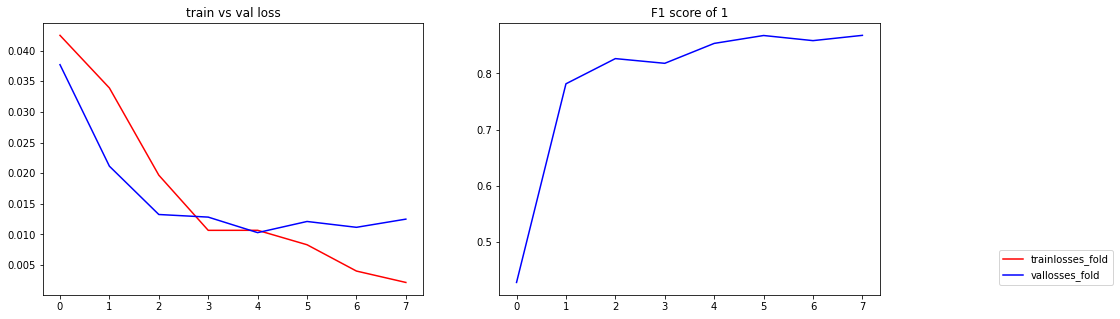

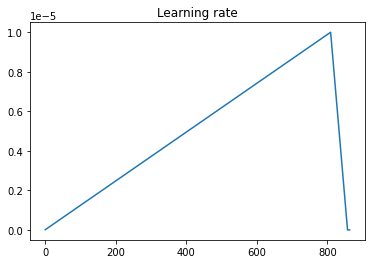

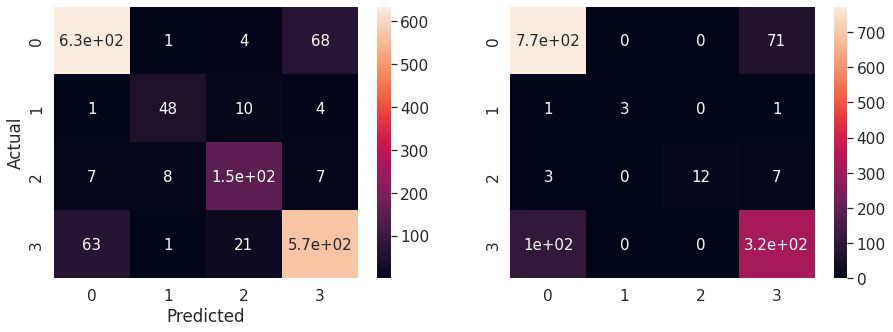

roberta-base
validation data -> 2: ['Form10k_61', 'Form10k_22', 'Form10k_14', 'Form10k_23'] 
['[NSEP]'] 4 2e-05
0:
2    502
0    499
3    434
1    188
Name: label, dtype: int64
------------
1:
0    5417
3    4769
2    1296
1     519
Name: label, dtype: int64
------------
Val0
0    874
3    437
2     16
1      3
Name: label, dtype: int64


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Val1
0    928
3    464
2     16
1      3
Name: label, dtype: int64


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


'len(traindatagp) :'

2

'len(valdatagp) :'

2

Max len :400
Size of the whole VAL dataset :1411
VAL Loader : batchsize 16  :89
Size of the whole TRAIN dataset :1623
TRAIN Loader :batchsize 16  :102
Validate after evey : 100 iterations
<<<<<<  Epoch: 1/2 OF CV: 2  >>>>>>


  0%|          | 0/102 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
 98%|█████████▊| 100/102 [01:43<00:17,  8.59s/it]

f1 score: 0.3161346835442975
best_trainloss: 0.041796083450317385
best_valoss: 0.03840127549299866


100%|██████████| 102/102 [01:45<00:00,  1.03s/it]


Size of the whole TRAIN dataset :12001
TRAIN Loader :batchsize 16  :751
Validate after evey : 100 iterations
<<<<<<  Epoch: 2/2 OF CV: 2  >>>>>>


 13%|█▎        | 99/751 [01:17<08:15,  1.32it/s]

f1 score: 0.7373983400357665
best_trainloss: 0.03357926368713379
best_valoss: 0.02332796699226874


 27%|██▋       | 200/751 [03:32<1:17:44,  8.47s/it]

f1 score: 0.8717768047754355
best_trainloss: 0.02098655104637146
best_valoss: 0.01126811211805957


 67%|██████▋   | 500/751 [08:44<35:34,  8.50s/it]

f1 score: 0.8863342229332499
best_trainloss: 0.0031739078958829244
best_valoss: 0.009826803445607466


 80%|███████▉  | 600/751 [10:30<21:29,  8.54s/it]

f1 score: 0.8779568903908133
best_trainloss: 0.008438384123146535
best_valoss: 0.009082839793237197


100%|██████████| 751/751 [12:52<00:00,  1.03s/it]


saving


,fold,f1_weighted,vallosses,trainlosses
0,1.0,0.853369,0.010301,0.010681
1,2.0,0.877957,0.009083,0.008438


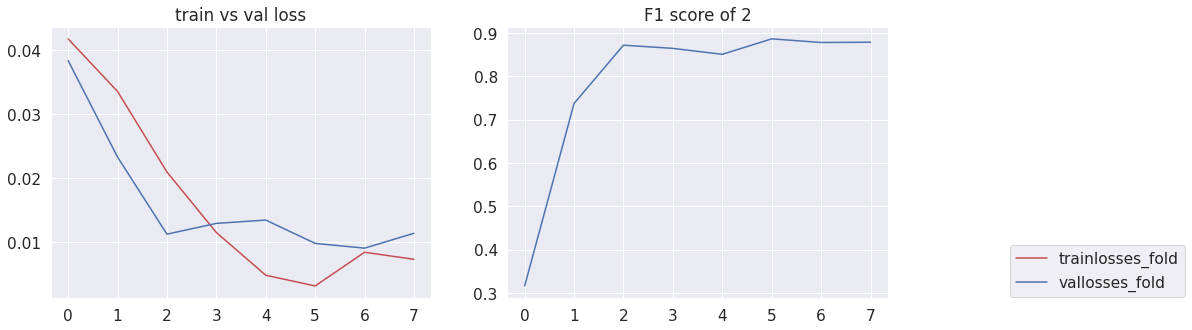

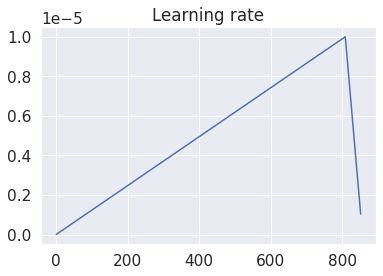

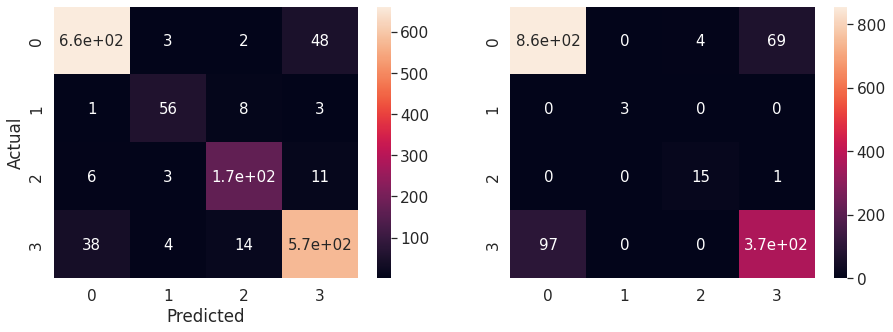

roberta-base
validation data -> 3: ['Form10k_63', 'Form10k_25', 'Form10k_34', 'Form10k_37'] 
['[NSEP]'] 4 2e-05
0:
2    502
0    497
3    434
1    188
Name: label, dtype: int64
------------
1:
0    5567
3    4923
2    1149
1     478
Name: label, dtype: int64
------------
Val0
0    794
3    397
2     65
1     20
Name: label, dtype: int64


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Val1
0    816
3    408
2     66
1     23
Name: label, dtype: int64


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


'len(traindatagp) :'

2

'len(valdatagp) :'

2

Max len :400
Size of the whole VAL dataset :1313
VAL Loader : batchsize 16  :83
Size of the whole TRAIN dataset :1621
TRAIN Loader :batchsize 16  :102
Validate after evey : 100 iterations
<<<<<<  Epoch: 1/2 OF CV: 3  >>>>>>


  0%|          | 0/102 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
 98%|█████████▊| 100/102 [01:37<00:15,  7.60s/it]

f1 score: 0.4565153488290383
best_trainloss: 0.041275634765625
best_valoss: 0.03661962417546612


100%|██████████| 102/102 [01:39<00:00,  1.03it/s]


Size of the whole TRAIN dataset :12117
TRAIN Loader :batchsize 16  :758
Validate after evey : 100 iterations
<<<<<<  Epoch: 2/2 OF CV: 3  >>>>>>


 13%|█▎        | 100/758 [01:41<1:24:29,  7.70s/it]

f1 score: 0.6019148686422414
best_trainloss: 0.031368597745895385
best_valoss: 0.02646439835168166


 26%|██▋       | 200/758 [03:22<1:10:32,  7.59s/it]

f1 score: 0.8152922439616763
best_trainloss: 0.01921207517385483
best_valoss: 0.015104233648313063


 53%|█████▎    | 400/758 [06:52<46:10,  7.74s/it]

f1 score: 0.8542837828256036
best_trainloss: 0.004657188989222049
best_valoss: 0.012078413528426403


 92%|█████████▏| 700/758 [11:51<07:18,  7.56s/it]

f1 score: 0.860131944962576
best_trainloss: 0.002271794341504574
best_valoss: 0.011957364169609791


100%|██████████| 758/758 [12:39<00:00,  1.00s/it]


saving


,fold,f1_weighted,vallosses,trainlosses
0,1.0,0.853369,0.010301,0.010681
1,2.0,0.877957,0.009083,0.008438
2,3.0,0.860132,0.011957,0.002272


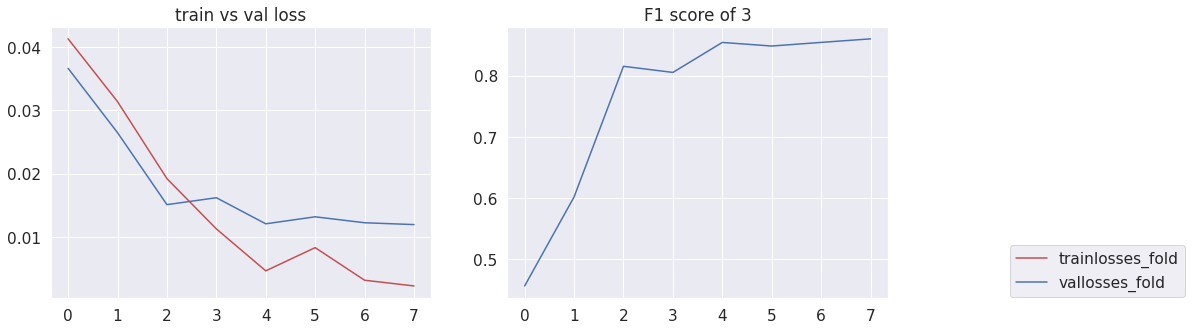

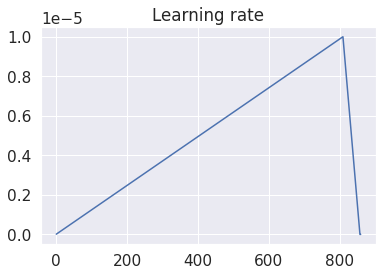

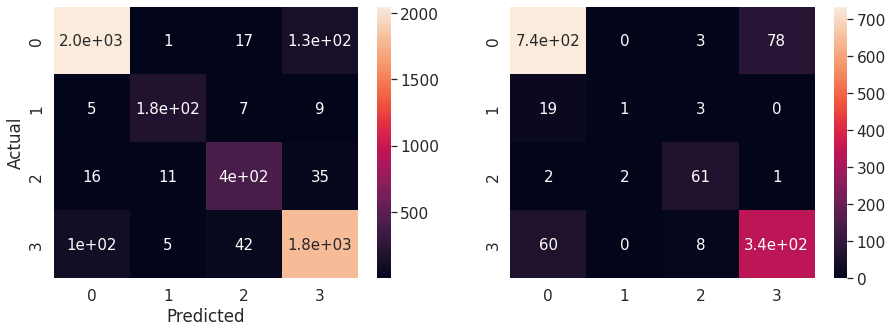

roberta-base
validation data -> 4: ['Form10k_55', 'Form10k_64', 'Form10k_60', 'Form10k_59'] 
['[NSEP]'] 4 2e-05
0:
2    502
0    500
3    434
1    188
Name: label, dtype: int64
------------
1:
0    6533
3    5735
2    1128
1     499
Name: label, dtype: int64
------------
Val0
0    188
3     94
2     73
1     10
Name: label, dtype: int64


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Val1
0    190
3     95
2     77
1     10
Name: label, dtype: int64


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,suid,sid,html_id,ori_sentence,label,title,tid,random,asentence,atid,arandom,bsentence,btid,brandom,sentence
0,Form10k_55tr-55-0035,tr-55-0035,Form10k_55,The Sky Terrace.,0,The Sky Terrace.,Form10k_55The Sky Terrace.,False,,Form10k_55The Sky Terrace is a unique structur...,False,,"Form10k_55The Atlantis has eight restaurants, ...",False,[The Sky Terrace. ] The Sky Terrace.
1,Form10k_55tr-55-0052,tr-55-0052,Form10k_55,"In 2020, the average occupancy rate at the Mon...",0,The tower also includes a private concierge lo...,Form10k_55The tower also includes a private co...,False,,Form10k_55Quality.,False,The tower also includes a private concierge lo...,Form10k_55The tower also includes a private co...,False,[The tower also includes a private concierge ...
2,Form10k_55tr-55-0053,tr-55-0053,Form10k_55,Quality.,0,Quality.,Form10k_55Quality.,False,,Form10k_55Established as high quality gaming r...,False,,Form10k_55The tower also includes a private co...,False,[Quality. ] Quality.


'len(traindatagp) :'

2

'len(valdatagp) :'

2

Max len :400
Size of the whole VAL dataset :372
VAL Loader : batchsize 16  :24
Size of the whole TRAIN dataset :1624
TRAIN Loader :batchsize 16  :102
Validate after evey : 100 iterations
<<<<<<  Epoch: 1/2 OF CV: 4  >>>>>>


  0%|          | 0/102 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
 98%|█████████▊| 100/102 [01:24<00:05,  2.83s/it]

f1 score: 0.4543601578334001
best_trainloss: 0.04289710998535156
best_valoss: 0.037642734265455634


100%|██████████| 102/102 [01:25<00:00,  1.19it/s]


Size of the whole TRAIN dataset :13895
TRAIN Loader :batchsize 16  :869
Validate after evey : 100 iterations
<<<<<<  Epoch: 2/2 OF CV: 4  >>>>>>


 12%|█▏        | 100/869 [01:26<38:09,  2.98s/it]

f1 score: 0.5312973098870385
best_trainloss: 0.03183765411376953
best_valoss: 0.03280089891725971


 23%|██▎       | 200/869 [02:51<31:25,  2.82s/it]

f1 score: 0.7722106344125981
best_trainloss: 0.020305557548999785
best_valoss: 0.017065919264750457


 35%|███▍      | 300/869 [04:20<28:37,  3.02s/it]

f1 score: 0.8011141962157778
best_trainloss: 0.013073338195681572
best_valoss: 0.013387504374227857


 58%|█████▊    | 500/869 [07:12<17:26,  2.83s/it]

f1 score: 0.836373115535345
best_trainloss: 0.0043009547144174575
best_valoss: 0.011935948605789372


 81%|████████  | 700/869 [10:05<08:22,  2.98s/it]

f1 score: 0.900635195048308
best_trainloss: 0.003985875509679318
best_valoss: 0.01006178870066119


100%|██████████| 869/869 [12:28<00:00,  1.16it/s]


saving


,fold,f1_weighted,vallosses,trainlosses
0,1.0,0.853369,0.010301,0.010681
1,2.0,0.877957,0.009083,0.008438
2,3.0,0.860132,0.011957,0.002272
3,4.0,0.900635,0.010062,0.003986


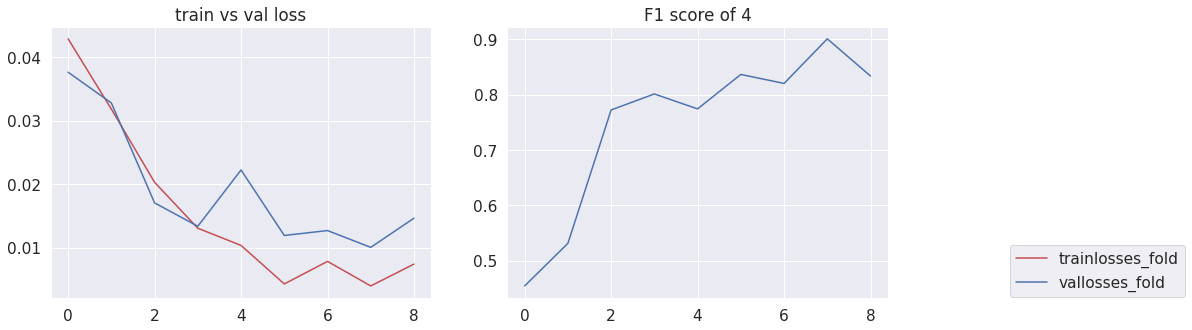

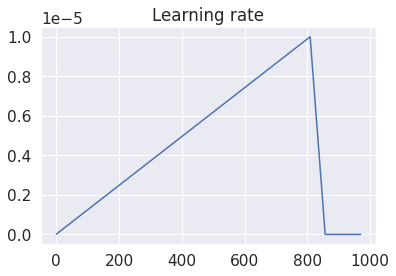

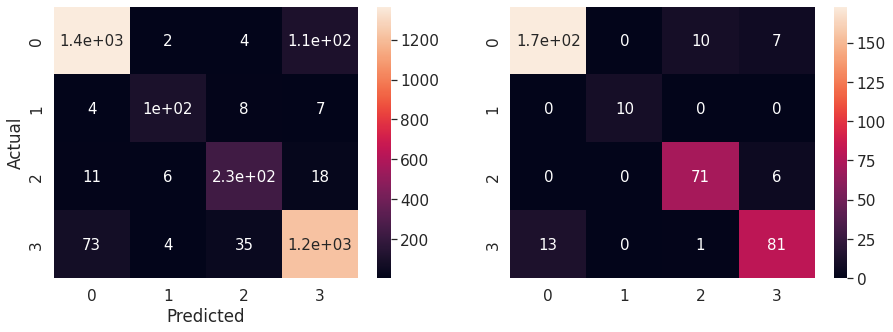

roberta-base
validation data -> 5: ['Form10k_57', 'Form10k_47', 'Form10k_12', 'Form10k_73'] 
['[NSEP]'] 4 2e-05
0:
2    502
0    496
3    434
1    188
Name: label, dtype: int64
------------
1:
0    6483
3    5735
2    1067
1     482
Name: label, dtype: int64
------------
Val0
0    204
3    102
2     97
1     15
Name: label, dtype: int64


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,suid,sid,html_id,sentence,label,title
0,Form10k_12tr-12-0011,tr-12-0011,Form10k_12,[ASC: FASB Accounting Standards Codification....,0,ASC: FASB Accounting Standards Codification.
1,Form10k_12tr-12-0065,tr-12-0065,Form10k_12,[MoGas Revolver: a $1.0 million secured revol...,0,MoGas Revolver: a $1.0 million secured revolvi...
2,Form10k_12tr-12-0067,tr-12-0067,Form10k_12,[Mowood/Omega Revolver: a $1.5 million secure...,0,Mowood/Omega Revolver: a $1.5 million secured ...


Val1
0    206
3    103
2    101
1     16
Name: label, dtype: int64


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,suid,sid,html_id,ori_sentence,label,title,tid,random,asentence,atid,arandom,bsentence,btid,brandom,sentence
0,Form10k_12tr-12-0010,tr-12-0010,Form10k_12,ARO: the Asset Retirement Obligation liabiliti...,0,ARO: the Asset Retirement Obligation liabiliti...,Form10k_12ARO: the Asset Retirement Obligation...,False,,Form10k_12ASC: FASB Accounting Standards Codif...,False,,Form10k_12as a result of the completion of a m...,False,[ARO: the Asset Retirement Obligation liabili...
1,Form10k_12tr-12-0035,tr-12-0035,Form10k_12,"Crimson: Crimson Midstream Holdings, LLC, a CP...",0,"Crimson: Crimson Midstream Holdings, LLC, a CP...","Form10k_12Crimson: Crimson Midstream Holdings,...",False,,Form10k_12Crimson Credit Facility: the Amended...,False,,Form10k_12CPUC: California Public Utility Comm...,False,"[Crimson: Crimson Midstream Holdings, LLC, a ..."
2,Form10k_12tr-12-0049,tr-12-0049,Form10k_12,FERC: Federal Energy Regulatory Commission.,0,FERC: Federal Energy Regulatory Commission.,Form10k_12FERC: Federal Energy Regulatory Comm...,False,,Form10k_12Four Wood Corridor: Four Wood Corrid...,False,,Form10k_12FASB: Financial Accounting Standards...,False,[FERC: Federal Energy Regulatory Commission. ...


'len(traindatagp) :'

2

'len(valdatagp) :'

2

Max len :400
Size of the whole VAL dataset :426
VAL Loader : batchsize 16  :27
Size of the whole TRAIN dataset :1620
TRAIN Loader :batchsize 16  :102
Validate after evey : 100 iterations
<<<<<<  Epoch: 1/2 OF CV: 5  >>>>>>


  0%|          | 0/102 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
 97%|█████████▋| 99/102 [01:17<00:02,  1.18it/s]

f1 score: 0.3717873781219258
best_trainloss: 0.04186717987060547
best_valoss: 0.03772819587882136


100%|██████████| 102/102 [01:27<00:00,  1.16it/s]


Size of the whole TRAIN dataset :13767
TRAIN Loader :batchsize 16  :861
Validate after evey : 100 iterations
<<<<<<  Epoch: 2/2 OF CV: 5  >>>>>>


 11%|█▏        | 99/861 [01:20<09:11,  1.38it/s]

f1 score: 0.5212863849765258
best_trainloss: 0.03162965893745422
best_valoss: 0.031153017996062696


 23%|██▎       | 200/861 [02:57<35:31,  3.23s/it]

f1 score: 0.8108320801717029
best_trainloss: 0.020978974997997283
best_valoss: 0.017461385621641165


 46%|████▋     | 400/861 [05:54<26:04,  3.39s/it]

f1 score: 0.8662668681043881
best_trainloss: 0.0050419259443879125
best_valoss: 0.014870572792576022


 81%|████████▏ | 700/861 [10:16<08:25,  3.14s/it]

f1 score: 0.8350573922864111
best_trainloss: 0.0023492964481314025
best_valoss: 0.012712811707396568


100%|██████████| 861/861 [12:37<00:00,  1.14it/s]


saving


,fold,f1_weighted,vallosses,trainlosses
0,1.0,0.853369,0.010301,0.010681
1,2.0,0.877957,0.009083,0.008438
2,3.0,0.860132,0.011957,0.002272
3,4.0,0.900635,0.010062,0.003986
4,5.0,0.835057,0.012713,0.002349


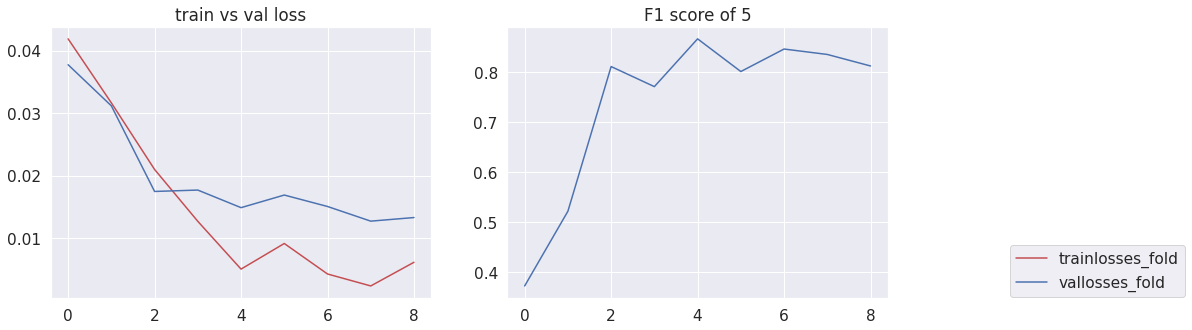

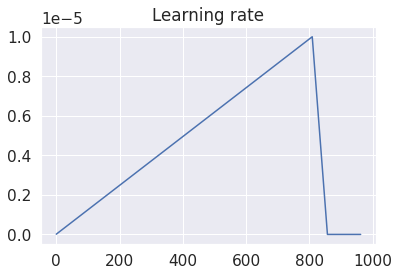

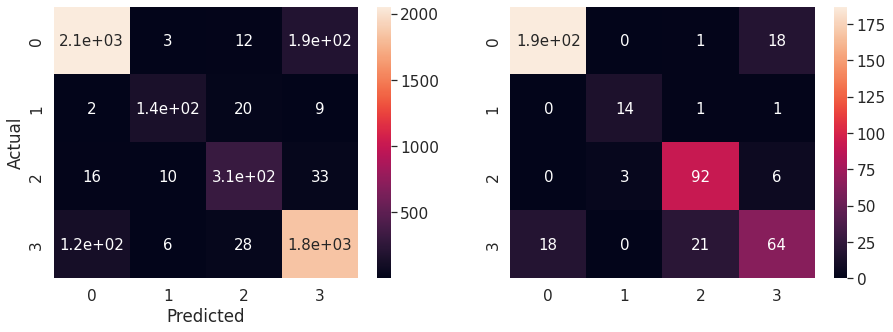

All CV loop finished.
output/roberta-base_2021_11_15-09:37:45_PM
Training finished.
MODELPATH_R : output/roberta-base_2021_11_15-09:37:45_PM/model/


,fold,f1_weighted,vallosses,trainlosses
0,1.0,0.853369,0.010301,0.010681
1,2.0,0.877957,0.009083,0.008438
2,3.0,0.860132,0.011957,0.002272
3,4.0,0.900635,0.010062,0.003986
4,5.0,0.835057,0.012713,0.002349


Model mean cv valloss score 0.01082318865315959
Model mean cv f1 score 0.8654300790645502


In [12]:
validx=1
print(f"Epoches Count : {EPOCHS}")
print("USE_AML ",USE_AML)
bestrecords=pd.DataFrame(columns=["fold","f1_weighted","vallosses","trainlosses"])
for fold in CV_DICT.keys():
    print(MODEL_NAME)
    print(f'validation data -> {fold}: {CV_DICT[fold]} ')
    tokenizer,model,optimizer= loadmodel(specialtoken=SEPCIAL_TOKEN)
    
    traindatagps,valdatagp =loadData(fold)
#     traindatagps,valdatagp =loadData(3)
    valdata=valdatagp[validx]
    if DEBUG:
        MAX_LEN =400
        train_params = {'batch_size': TRAIN_BATCH_SIZE,
                       'pin_memory': True,
                        'num_workers': 0,
                        'shuffle':True
                        }
    
        val_params = {'batch_size': VALID_BATCH_SIZE,
                        'pin_memory': True,
                        'num_workers': 0
                     }
        valdata=valdata[:DEBUG_DATA_SIZE]
    else:
        data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
        train_params = {'batch_size': TRAIN_BATCH_SIZE,
                        'pin_memory': True,
                        'num_workers': 0,
                        'collate_fn':data_collator,
                        'shuffle':True
                        }
    
        val_params = {'batch_size': VALID_BATCH_SIZE,
                        'pin_memory': True,
                        'num_workers': 0,
                      'collate_fn':data_collator
                        }
        
    valset = CustomDataset(valdata, tokenizer, MAX_LEN)
    val_dataloader = DataLoader(valset, **val_params)
    if USE_SCHEDULER:
        scheduler = transformers.get_linear_schedule_with_warmup(                
                 optimizer = optimizer,
                 num_warmup_steps = warmup_step,
                 num_training_steps = int(num_training_steps_wepoch/TRAIN_BATCH_SIZE))
#         scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
    
    bestscore = None
    le=[]
    vallosses_fold=[]
    trainlosses_fold=[]
    f1_weighted_fold=[]
    
    print(f"Max len :{MAX_LEN}")
    print(f"Size of the whole VAL dataset :{len(val_dataloader.dataset)}")
    print(f"VAL Loader : batchsize {VALID_BATCH_SIZE}  :{len(val_dataloader)}")
    bestCM_train={'target':[],'pred':[]}
    bestCM_val={'target':[],'pred':[]}
    state={}
    scaler=torch.cuda.amp.GradScaler()

    for epoch in range(EPOCHS):
        bestlostfound=False
        traindata=traindatagps[epoch]
        if DEBUG:
            traindata=traindata[:DEBUG_DATA_SIZE+10]
        trainset = CustomDataset(traindata, tokenizer, MAX_LEN)
        train_dataloader = DataLoader(trainset, **train_params)
        print(f"Size of the whole TRAIN dataset :{len(train_dataloader.dataset)}")
        print(f"TRAIN Loader :batchsize {TRAIN_BATCH_SIZE}  :{len(train_dataloader)}")
        print(f"Validate after evey : 100 iterations")
        print(f"<<<<<<  Epoch: {epoch+1}/{EPOCHS} OF CV: {fold}  >>>>>>")        
        traintargets=[] # record only best 
        trainpreds=[]  # record only best 
#         trainlosses=[]  # alltrain loss
        total_loss = 0
        model.train()
        optimizer.zero_grad()
        for step,batch in enumerate(tqdm(train_dataloader)):
            
            batch = {k: v.to(device) for k, v in batch.items()}
            
            with torch.cuda.amp.autocast():
                outputs = model(**batch)
                loss,logits=outputs[:2]
                
            targets=batch['labels'].cpu().detach().numpy()
            traintargets.extend(targets)
            
            del batch,outputs,targets
            _ = gc.collect()
            torch.cuda.empty_cache()
            
            if USE_AML:
                loss=loss/ACCUMULATION_STEPS

            
            if L== True:
                scaler.scale(loss).backward()
            else:
                loss.backward()

            if USE_AML:
                if (step+1)%ACCUMULATION_STEPS == 0:
                    if L== True:
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        optimizer.step()
                    optimizer.zero_grad()
            else:
                optimizer.step()
                optimizer.zero_grad()
                
           
            total_loss = total_loss + loss.item()
            outputs=logits.cpu().detach().numpy()    
            outputs=np.argmax(outputs, axis=1)
            trainpreds.extend(outputs)
            
            del logits,loss,outputs
            _ = gc.collect()
            torch.cuda.empty_cache()
            
            if USE_SCHEDULER:
                scheduler.step()
                le.append(scheduler.get_last_lr()[0])
#                 if ((step+1) % 100 == 0 ):
# #                     print(f"lr:{scheduler.get_last_lr()[0]:.20f}")
#                     le.append(scheduler.get_last_lr()[0])
#                     scheduler.step()
                
#             if ((step+1) % int(len(train_dataloader)/10) == 0):
            
            if DEBUG:
                validatepoint=int(len(train_dataloader)/2)
            else:
                validatepoint=100
            if (((step+1) % validatepoint == 0)):
                valtargets,valpreds,vallogits,valloss=validate(model,val_dataloader)
                model.train()
               
                trainlosses_fold.append(total_loss/len(traintargets))
                total_loss=0
                vallosses_fold.append(valloss)
                f1_weighted_fold.append(f1_score(valtargets, valpreds, average='weighted'))
                if bestscore is None or round(bestscore,5) >= round(valloss,5):
                    bestlostfound=True
                    bestscore=valloss
                    state = {
                        'state_dict': deepcopy(model.state_dict()),
                        'optimizer_dict': deepcopy(optimizer.state_dict()),
                        'epoch':epoch,
                        'step':step,
                        'f1_weighted':f1_weighted_fold[-1],
                        'trainlosses':trainlosses_fold[-1],
                        'vallosses':vallosses_fold[-1]
                                }

                    best_vallogits=vallogits
                    bestCM_train['target'] =traintargets
                    bestCM_train['pred'] =trainpreds
                    bestCM_val['target'] =valtargets
                    bestCM_val['pred'] =valpreds   
                    print('f1 score:',f1_weighted_fold[-1])
                    print('best_trainloss:',trainlosses_fold[-1])
                    print('best_valoss:',vallosses_fold[-1])
                    traintargets=[] # record only best 
                    trainpreds=[]  # record only best 
        
                del valtargets,valpreds,valloss,vallogits
                _ = gc.collect()
                torch.cuda.empty_cache()

        del trainset,train_dataloader,traintargets,trainpreds
        _ = gc.collect()
        torch.cuda.empty_cache()
        if bestlostfound == False:
            break
    print("saving")
    
    fullpathOutput="{}/model/{}_e{}_v{:.3f}_fold{}"
    fullpathChkpt=fullpathOutput.format(OUT_BASEPATH,smodelname,epoch,state["vallosses"],int(fold))
    
    torch.save(state, fullpathChkpt+".pth")
    bestrecords=bestrecords.append({'fold': int(fold),
                                'f1_weighted': state["f1_weighted"],
                                'vallosses': state["vallosses"],
                                'trainlosses':state["trainlosses"],
                               },
                               ignore_index=True)   
    display(bestrecords)
    

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
    
    ax1.plot(trainlosses_fold,'r',label="trainlosses_fold")
    ax1.plot(vallosses_fold,'b',label="vallosses_fold")
    ax1.title.set_text("train vs val loss")
    ax1.legend(loc='center left', bbox_to_anchor=(2.5, 0.1))
    ax2.title.set_text(f"F1 score of {fold}")
    ax2.plot(f1_weighted_fold,'b',label="f1_weighted_fold")
    plt.show()
    if USE_SCHEDULER:
        plt.title("Learning rate")
        x = np.arange(len(le))
        plt.plot(x,le)
        plt.show()
    doconfusion_matrix(bestCM_train['target'],bestCM_train['pred'],bestCM_val['target'],bestCM_val['pred']) 
    
    f1_sco= round(state["f1_weighted"],3)        
    los=round(state["vallosses"],3)    


    valdata[f'logits{fold}_f{f1_sco}_v{los}_{uname}']=best_vallogits
    valdata[f"predictions_{uname}"]=bestCM_val['pred']
    valdata[f'targets{fold}_{uname}']=bestCM_val['target']
    valdata[f'confidence_{uname}']=valdata[f'logits{fold}_f{f1_sco}_v{los}_{uname}'].apply(lambda x:np.array([torch.sigmoid(torch.tensor(i)).numpy()*100 for i in x ]))
    
    torch.save(valdata,f"{smodelname[0]}Valpred{fold}.pkl")
#     valdata.to_csv(fullpathChkpt+".tsv", sep="\t")
    
    del model,optimizer,tokenizer,state,vallosses_fold,valdata,trainlosses_fold,f1_weighted_fold
    scaler
    _ = gc.collect()
    torch.cuda.empty_cache()
print("All CV loop finished.")



date = datetime.now().strftime("_%Y_%m_%d-%I:%M:%S_%p")
MODELPATH_R=OUT_BASEPATH+date
print(MODELPATH_R)

print("Training finished.")
os.rename(OUT_BASEPATH,MODELPATH_R)
MODELPATH_R=MODELPATH_R+"/model/"
print("MODELPATH_R :",MODELPATH_R)

display(bestrecords)
print(f"Model mean cv valloss score {bestrecords['vallosses'].mean()}")
print(f"Model mean cv f1 score {bestrecords['f1_weighted'].mean()}")
del bestrecords
_ = gc.collect()
torch.cuda.empty_cache()

In [13]:
# validx=1
# print(f"Epoches Count : {EPOCHS}")
# print("USE_AML ",USE_AML)
# bestrecords=pd.DataFrame(columns=["fold","f1_weighted","vallosses","trainlosses"])
# for fold in CV_DICT.keys():
#     print(MODEL_NAME)
#     print(f'validation data -> {fold}: {CV_DICT[fold]} ')
#     tokenizer,model,optimizer= loadmodel(specialtoken=SEPCIAL_TOKEN)
    
#     traindatagps,valdata =loadData(fold)
# #     traindatagps,valdatagp =loadData(3)
#     valdata=valdatagp[validx]
#     if DEBUG:
#         MAX_LEN =400
#         train_params = {'batch_size': TRAIN_BATCH_SIZE,
#                        'pin_memory': True,
#                         'num_workers': 0,
#                         'shuffle':True
#                         }
    
#         val_params = {'batch_size': VALID_BATCH_SIZE,
#                         'pin_memory': True,
#                         'num_workers': 0
#                      }
#         valdata=valdata[:DEBUG_DATA_SIZE]
#     else:
#         data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#         train_params = {'batch_size': TRAIN_BATCH_SIZE,
#                         'pin_memory': True,
#                         'num_workers': 0,
#                         'collate_fn':data_collator,
#                         'shuffle':True
#                         }
    
#         val_params = {'batch_size': VALID_BATCH_SIZE,
#                         'pin_memory': True,
#                         'num_workers': 0,
#                       'collate_fn':data_collator
#                         }
        
#     valset = CustomDataset(valdata, tokenizer, MAX_LEN)
#     val_dataloader = DataLoader(valset, **val_params)
#     if USE_SCHEDULER:
#         scheduler = transformers.get_linear_schedule_with_warmup(                
#                  optimizer = optimizer,
#                  num_warmup_steps = 110,
#                  num_training_steps = int(num_training_steps_wepoch/TRAIN_BATCH_SIZE))
# #         scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
    
#     bestscore = None
#     le=[]
#     vallosses_fold=[]
#     trainlosses_fold=[]
#     f1_weighted_fold=[]
     
#     print(f"Max len :{MAX_LEN}")
#     print(f"Size of the whole VAL dataset :{len(val_dataloader.dataset)}")
#     print(f"VAL Loader : batchsize {VALID_BATCH_SIZE}  :{len(val_dataloader)}")
#     bestCM_train={'target':[],'pred':[]}
#     bestCM_val={'target':[],'pred':[]}
#     state={}
#     scaler=torch.cuda.amp.GradScaler()

#     for epoch in range(EPOCHS):
#         bestlostfound=False
#         traindata=traindatagps[epoch]
#         if DEBUG:
#             traindata=traindata[:DEBUG_DATA_SIZE+10]
#         trainset = CustomDataset(traindata, tokenizer, MAX_LEN)
        
#         train_dataloader = DataLoader(trainset, **train_params)
#         print(f"Size of the whole TRAIN dataset :{len(train_dataloader.dataset)}")
#         print(f"TRAIN Loader :batchsize {TRAIN_BATCH_SIZE}  :{len(train_dataloader)}")
#         print(f"Validate after evey : 100 iterations")
#         print(f"<<<<<<  Epoch: {epoch+1}/{EPOCHS} OF CV: {fold}  >>>>>>")        
#         traintargets=[] # record only best 
#         trainpreds=[]  # record only best 
# #         trainlosses=[]  # alltrain loss
#         total_loss = 0
#         model.train()
#         optimizer.zero_grad()
#         for step,batch in enumerate(tqdm(train_dataloader)):
            
#             batch = {k: v.to(device) for k, v in batch.items()}
            
#             with torch.cuda.amp.autocast():
#                 outputs = model(**batch)
#                 loss,logits=outputs[:2]
                
#             targets=batch['labels'].cpu().detach().numpy()
#             traintargets.extend(targets)
            
#             del batch,outputs,targets
#             _ = gc.collect()
#             torch.cuda.empty_cache()
            
#             if USE_AML:
#                 loss=loss/ACCUMULATION_STEPS

            
#             if L== True:
#                 scaler.scale(loss).backward()
#             else:
#                 loss.backward()

#             if USE_AML:
#                 if (step+1)%ACCUMULATION_STEPS == 0:
#                     if L== True:
#                         scaler.step(optimizer)
#                         scaler.update()
#                     else:
#                         optimizer.step()
#                     optimizer.zero_grad()
#             else:
#                 optimizer.step()
#                 optimizer.zero_grad()
                
           
#             total_loss = total_loss + loss.item()
#             outputs=logits.cpu().detach().numpy()    
#             outputs=np.argmax(outputs, axis=1)
#             trainpreds.extend(outputs)
            
#             del logits,loss,outputs
#             _ = gc.collect()
#             torch.cuda.empty_cache()
            
#             if USE_SCHEDULER:
#                 scheduler.step()
# #                 if ((step+1) % 100 == 0 ):
# # #                     print(f"lr:{scheduler.get_last_lr()[0]:.20f}")
# #                     le.append(scheduler.get_last_lr()[0])
# #                     scheduler.step()
                
# #             if ((step+1) % int(len(train_dataloader)/10) == 0):

#             if (((step+1) % 100 == 0)):
#                 valtargets,valpreds,vallogits,valloss=validate(model,val_dataloader)
#                 model.train()
               
#                 trainlosses_fold.append(total_loss/len(traintargets))
#                 total_loss=0
#                 vallosses_fold.append(valloss)
#                 f1_weighted_fold.append(f1_score(valtargets, valpreds, average='weighted'))
#                 if bestscore is None or round(bestscore,5) >= round(valloss,5):
#                     bestlostfound=True
#                     bestscore=valloss
#                     state = {
#                         'state_dict': deepcopy(model.state_dict()),
#                         'optimizer_dict': deepcopy(optimizer.state_dict()),
#                         'epoch':epoch,
#                         'step':step,
#                         'f1_weighted':f1_weighted_fold[-1],
#                         'trainlosses':trainlosses_fold[-1],
#                         'vallosses':vallosses_fold[-1]
#                                 }

#                     best_vallogits=vallogits
#                     bestCM_train['target'] =traintargets
#                     bestCM_train['pred'] =trainpreds
#                     bestCM_val['target'] =valtargets
#                     bestCM_val['pred'] =valpreds   
#                     print('f1 score:',f1_weighted_fold[-1])
#                     print('best_trainloss:',trainlosses_fold[-1])
#                     print('best_valoss:',vallosses_fold[-1])
#                     traintargets=[] # record only best 
#                     trainpreds=[]  # record only best 
        
#                 del valtargets,valpreds,valloss,vallogits
#                 _ = gc.collect()
#                 torch.cuda.empty_cache()

#         del trainset,train_dataloader,traintargets,trainpreds
#         _ = gc.collect()
#         torch.cuda.empty_cache()
#         if bestlostfound == False:
#             break
#     print("saving")
#     model.load_state_dict(checkpoint['state_dict'])
#     model.to(device)
#     testdata=PredictTest(model,test_loader,testdata)
    
#     fullpathOutput="{}/model/{}_e{}_v{:.3f}_fold{}"
#     fullpathChkpt=fullpathOutput.format(OUT_BASEPATH,smodelname,epoch,state["vallosses"],int(fold))
    
#     torch.save(state, fullpathChkpt+".pth")
#     bestrecords=bestrecords.append({'fold': int(fold),
#                                 'f1_weighted': state["f1_weighted"],
#                                 'vallosses': state["vallosses"],
#                                 'trainlosses':state["trainlosses"],
#                                },
#                                ignore_index=True)   
#     display(bestrecords)
    

#     fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
    
#     ax1.plot(trainlosses_fold,'r',label="trainlosses_fold")
#     ax1.plot(vallosses_fold,'b',label="vallosses_fold")
#     ax1.title.set_text("train vs val loss")
#     ax1.legend(loc='center left', bbox_to_anchor=(2.5, 0.1))
#     ax2.title.set_text(f"F1 score of {fold}")
#     ax2.plot(f1_weighted_fold,'b',label="f1_weighted_fold")
#     plt.show()
#     if USE_SCHEDULER:
#         plt.title("Learning rate")
#         x = np.arange(len(le))
#         plt.plot(x,le)
#         plt.show()
#     doconfusion_matrix(bestCM_train['target'],bestCM_train['pred'],bestCM_val['target'],bestCM_val['pred']) 
    
#     f1_sco= round(state["f1_weighted"],3)        
#     los=round(state["vallosses"],3)    


#     valdata[f'logits{fold}_f{f1_sco}_v{los}_{uname}']=best_vallogits
#     valdata[f"predictions_{uname}"]=bestCM_val['pred']
#     valdata[f'targets{fold}_{uname}']=bestCM_val['target']
#     valdata[f'confidence_{uname}']=valdata[f'logits{fold}_f{f1_sco}_v{los}_{uname}'].apply(lambda x:np.array([torch.sigmoid(torch.tensor(i)).numpy()*100 for i in x ]))
    
#     torch.save(valdata,f"{smodelname[0]}Valpred{fold}.pkl")
# #     valdata.to_csv(fullpathChkpt+".tsv", sep="\t")
    
#     del model,optimizer,tokenizer,state,vallosses_fold,valdata,trainlosses_fold,f1_weighted_fold
#     scaler
#     _ = gc.collect()
#     torch.cuda.empty_cache()
# print("All CV loop finished.")

# Testoutputfilename=f"{smodelname[0]}FNTestpreds"
# print("saving test")
# torch.save(FNcctest_df,outputfilename+".pkl")
# FNcctest_df.to_csv(outputfilename+".tsv", sep="\t",index=False)
    

# date = datetime.now().strftime("_%Y_%m_%d-%I:%M:%S_%p")
# MODELPATH_R=OUT_BASEPATH+date
# print(MODELPATH_R)

# print("Training finished.")
# os.rename(OUT_BASEPATH,MODELPATH_R)
# MODELPATH_R=MODELPATH_R+"/model/"
# print("MODELPATH_R :",MODELPATH_R)

# display(bestrecords)
# print(f"Model mean cv valloss score {bestrecords['vallosses'].mean()}")
# print(f"Model mean cv f1 score {bestrecords['f1_weighted'].mean()}")
# del bestrecords
# _ = gc.collect()
# torch.cuda.empty_cache()

In [14]:
# # VAL
# val=1
# bestrecords=pd.DataFrame(columns=["fold","f1_weighted","vallosses""f1_weighted2"])
# for fold in CV_DICT.keys():
#     print(fold)
#     print(MODEL_NAME)
#     print(f'validation data -> {fold}: {CV_DICT[fold]} ')
#     _,valdatagp =loadData(fold)
#     valdata=valdatagp[val]
#     tokenizer,model,optimizer= loadmodel(MODEL_NAME,specialtoken=SEPCIAL_TOKEN)
    
#     optimizer, _ = roberta_base_AdamW_grouped_LLRD(model)
#     modelpath =list(glob.glob(MODELPATH_R+"/"+"*fold{}.pth".format(fold)))[0]
# #     modelpath=[m for m in modellist if "_fold{}".format(fold) in m][0]
#     print(modelpath)
#     checkpoint = torch.load(modelpath)
    
#     model.load_state_dict(checkpoint['state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_dict'])
#     model.eval()
    
    
#     if DEBUG:
#         MAX_LEN =400
#         val_params = {'batch_size': VALID_BATCH_SIZE,
#                         'num_workers': 0
#                      }
#         valdata=valdata[:DEBUG_DATA_SIZE]
#     else:
#         data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#         val_params = {'batch_size': VALID_BATCH_SIZE,
#                         'num_workers': 0,
#                       'collate_fn':data_collator
#                         }
        
        
#     trainset = CustomDataset(valdata, tokenizer, MAX_LEN)
    
#     test_dataloader=DataLoader(trainset,**val_params)
#     del modelpath,checkpoint
#     torch.cuda.empty_cache()
    
#     logitsoutput=[]
#     batchtargets=[]
#     batchoutputs=[]
#     batchloss=[]
    
#     with torch.no_grad():
#         for i,batch in enumerate(tqdm(test_dataloader)):
#             batch = {k: v.to(device) for k, v in batch.items()}
#             outputs = model(**batch)
#             loss,logits=outputs[:2]
#             logitsoutput.extend(logits.cpu().detach().numpy())
            
#             targets=batch['labels'].cpu().detach().numpy()
#             batchtargets.extend(targets)
            
#             if USE_AML:
#                 batchloss.append(loss.item()/ACCUMULATION_STEPS)
#             else:
#                 batchloss.append(loss.item())

#             outputs=logits.cpu().detach().numpy()    
#             outputs=np.argmax(outputs, axis=1)
#             batchoutputs.extend(outputs)
            
#     f1_socre= round(f1_score(batchtargets, batchoutputs, average='weighted'),3)        
#     loss=round(np.mean(batchloss),3)       
#     valdata[f'logits{fold}_f{f1_socre}_v{loss}_dbca']=logitsoutput
#     valdata[f'targets{fold}_dbca']=batchtargets
#     valdata[f'predictions{fold}_dbca']=valdata[f'logits{fold}_f{f1_socre}_v{loss}_dbca'].apply(lambda x:x.argmax())
#     valdata[f'confidence{fold}_dbca']=valdata[f'logits{fold}_f{f1_socre}_v{loss}_dbca'].apply(lambda x:np.array([torch.sigmoid(torch.tensor(i)).numpy()*100 for i in x ]))
#     torch.save(valdata,f"{smodelname[0]}chkValpred{fold}.pkl")

#     valdata.to_csv(f"{MODEL_NAME.split('/')[-1]}_{val}Testpreds{fold}.tsv", sep="\t",index=False)
#     bestrecords=bestrecords.append({'fold': int(fold),
#                                 'f1_weighted': f1_socre,
#                                 'vallosses':loss,
#                                },
#                                ignore_index=True)   
#     display(bestrecords)
#     doconfusion_matrix_one(batchtargets,batchoutputs)         
    

#     del model,optimizer
#     _= gc.collect()
#     torch.cuda.empty_cache()



#### CHECK CREATED MODEL

In [15]:
# modellist={"../input/psdebertanotokenv1/output/deberta-base_2021_11_11-08:08:00_PM/model/deberta-base_e0_v0.059_fold2.pth",
# "../input/psdebertanotokenv1/output/deberta-base_2021_11_11-08:08:00_PM/model/deberta-base_e0_v0.061_fold1.pth",
# "../input/psdebertanotokenv1/output/deberta-base_2021_11_11-08:08:00_PM/model/deberta-base_e4_v0.078_fold3.pth"}

In [16]:
# #TEST
# # test=testdata.copy()
# testidx=1
# testlist=[testdata,abtestdata]
# testno=0
# test=testlist[testidx]
# for fold in CV_DICT.keys():
#     print(fold)
#     print(MODEL_NAME)
    
#     tokenizer,model,optimizer= loadmodel(MODEL_NAME,specialtoken=SEPCIAL_TOKEN)
    
#     modelpath =list(glob.glob(MODELPATH_R+"*fold{}.pth".format(fold)))[0]
    
# #     modelpath=[m for m in modellist if "_fold{}".format(fold) in m][0]

#     print(modelpath)
#     checkpoint = torch.load(modelpath)

#     model.load_state_dict(checkpoint['state_dict'])

#     model.eval()

#     del modelpath,checkpoint
#     torch.cuda.empty_cache()
    
    
#     if DEBUG:
#         MAX_LEN =400
#         test_params = {'batch_size': VALID_BATCH_SIZE,
#                         'pin_memory': True,
#                         'num_workers': 0
#                      }
#         test=test[:DEBUG_DATA_SIZE]
#     else:
#         data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#         test_params = {'batch_size': VALID_BATCH_SIZE,
#                         'pin_memory': True,
#                         'num_workers': 0,
#                       'collate_fn':data_collator
#                         }
    
    
    
#     testset = CustomDataset(test, tokenizer, MAX_LEN,labelexist=False)
#     test_dataloader=DataLoader(testset,**test_params)
    

#     logitsoutput=[]
#     with torch.no_grad():
#         for i,batch in enumerate(tqdm(test_dataloader)):
#             batch = {k: v.to(device) for k, v in batch.items()}
#             outputs = model(**batch)
#             logitsoutput.extend(outputs.logits.cpu().detach().numpy())
            
#     test[f'logits{fold}']=logitsoutput
#     test[f'predictions{fold}']=test[f'logits{fold}'].apply(lambda x:x.argmax())
#     test[f'confidence{fold}']=test[f'logits{fold}'].apply(lambda x:np.array([torch.sigmoid(torch.tensor(i)).numpy()*100 for i in x ]))
        
        


#     del model
#     torch.cuda.empty_cache()
# # fullpathOutput="{}/{}_e{}_v{:.3f}_fold{}"
# # fullpathChkpt=fullpathOutput.format(OUT_BASEPATH,MODEL_NAME.split('/')[-1],epoch,state["vallosses"],int(fold))

# # fullpathPreds=f"{outputpath}/{modelname.split('/')[-1]}_testpreds.pkl"
# # test.to_pickle(fullpathPreds)
# fullpathOutput="{}/{}_fold{}".format(OUT_BASEPATH,smodelname,int(fold))
# # test.to_csv(fullpathOutput+f"{testidx}Testpreds.tsv", sep="\t",index=False)
# torch.save(test,f"{smodelname[0]}Testpreds.pkl")


# print("Training finished.")
# # os.rename(OUT_BASEPATH,MODELPATH_R)
# # print("MODELPATH_R :",MODELPATH_R)


# # # preds=pd.read_pickle(fullpathPreds)
# # logits_col = [col for col in test if col.startswith('logit')]
# # test['FNlogit']=sum(test[column].to_numpy() for column in test[logits_col])/len(logits_col)
# # test['FNprediction']=test['FNlogit'].apply(lambda x:x.argmax())
# # test['FNtop2class']=test['FNlogit'].apply(lambda x:x.argsort()[-2:][::-1])
# # test['FNftop2class']=test['FNlogit'].apply(lambda x:x.argsort()[-2:][::-1])
# # test['FNconfidences']=test['FNlogit'].apply(lambda x:np.array([torch.sigmoid(torch.tensor(i)).numpy()*100 for i in x ]))
# # test['FNtopconf2']=test['FNconfidences'].apply(lambda x:x[x.argsort()[-2:][::-1]])
# # test['FNpredconf']=test['FNtopconf2'].apply(lambda x:x[x.argmax()])

# # # preds.to_csv("final.tsv", sep="\t",index=False)
# # test['FNcondiff']=test['FNtopconf2'].apply(lambda x:x[0]-x[1])
# # test.to_csv(f"{MODEL_NAME.split('/')[-1]}_testpredictions.tsv", sep="\t",index=False)

# # pred123=test[(test.FNprediction!=0) & (test.FNcondiff>15)& (test.FNpredconf>95)]
# # print(pred123.FNprediction.value_counts())
# # pred123.to_csv(f"{MODEL_NAME.split('/')[-1]}_pseudolabels.tsv", sep="\t",index=False)

### Testdata

1
roberta-base
['[NSEP]'] 4 2e-05
output/roberta-base_2021_11_15-09:37:45_PM/model/roberta-base_e1_v0.010_fold1.pth
validation data -> 1: ['Form10k_65', 'Form10k_44', 'Form10k_74', 'Form10k_01'] 


100%|██████████| 619/619 [01:00<00:00, 10.27it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

saving


,fold,f1_weighted,vallossesf1_weighted2,vallosses
0,1.0,0.936,NaN,0.091


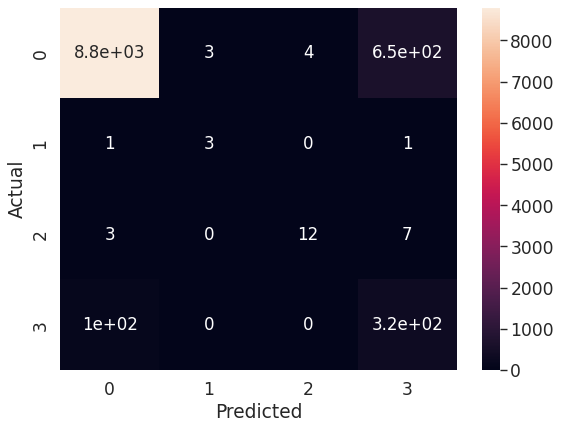

In [17]:
def GetPredictions(outputfilename,testdata=None,labelexist=False):
    if labelexist :
        bestrecords=pd.DataFrame(columns=["fold","f1_weighted","vallosses""f1_weighted2"])
    for fold in CV_DICT.keys():
        print(fold)
        print(MODEL_NAME)
        
        tokenizer,model,optimizer= loadmodel(specialtoken=SEPCIAL_TOKEN)
        modelpath =list(glob.glob(MODELPATH_R+"/"+"*fold{}.pth".format(fold)))[0]
    #     modelpath=[m for m in modellist if "_fold{}".format(fold) in m][0]
        print(modelpath)
        checkpoint = torch.load(modelpath)
        
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_dict'])
        model.eval()
        
        if testdata is None :        
            print(f'validation data -> {fold}: {CV_DICT[fold]} ')
#             _,testdata =loadData(fold) 
#             testdata=testdata[1]
            testdata=valab_df[valab_df['html_id'].isin(CV_DICT[fold])]
            testdata.reset_index(drop=True,inplace=True)

        if DEBUG:
            val_params = {'batch_size': VALID_BATCH_SIZE,
                            'num_workers': 0
                         }
            testdata=testdata[:DEBUG_DATA_SIZE]

        else:
            data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
            val_params = {'batch_size': VALID_BATCH_SIZE,
                            'num_workers': 0,
                          'collate_fn':data_collator
                            }
            
           
        trainset = CustomDataset(testdata, tokenizer, MAX_LEN,labelexist)
        
        test_dataloader=DataLoader(trainset,**val_params)
        del modelpath,checkpoint
        torch.cuda.empty_cache()
        
        logitsoutput=[]
        batchtargets=[]
        batchoutputs=[]
        batchloss=[]
        
        
        with torch.no_grad():
            for i,batch in enumerate(tqdm(test_dataloader)):
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                if labelexist:
                    loss,logits=outputs[:2]
                    targets=batch['labels'].cpu().detach().numpy()
                    batchtargets.extend(targets)
                    
                    if USE_AML:
                        batchloss.append(loss.item()/ACCUMULATION_STEPS)
                    else:
                        batchloss.append(loss.item())
            
                    outputs=logits.cpu().detach().numpy()    
                    outputs=np.argmax(outputs, axis=1)
                    batchoutputs.extend(outputs)
                else:
                    loss,logits=outputs[:2]
                logitsoutput.extend(logits.cpu().detach().numpy())
        if labelexist :        
            f1_socre= round(f1_score(batchtargets, batchoutputs, average='weighted'),3)        
            loss=round(np.mean(batchloss),3)       
            testdata[f'logits{fold}_f{f1_socre}_v{loss}_{uname}']=logitsoutput
            testdata[f'targets{fold}_{uname}']=batchtargets
            testdata[f'predictions{fold}_{uname}']=testdata[f'logits{fold}_f{f1_socre}_v{loss}_{uname}'].apply(lambda x:x.argmax())
            testdata[f'confidence{fold}_{uname}']=testdata[f'logits{fold}_f{f1_socre}_v{loss}_{uname}'].apply(lambda x:np.array([torch.sigmoid(torch.tensor(i)).numpy()*100 for i in x ]))
#             outputPath=f"{smodelname[0]}chkValpred{fold}"
            print("saving")
            torch.save(testdata,outputfilename+".pkl")
            testdata.to_csv(outputfilename+".tsv", sep="\t",index=False)
            bestrecords=bestrecords.append({'fold': int(fold),
                                    'f1_weighted': f1_socre,
                                    'vallosses':loss,
                                   },
                                   ignore_index=True)   
            display(bestrecords)
            doconfusion_matrix_one(batchtargets,batchoutputs)        
            
        
        else:
            testdata[f'logits{fold}']=logitsoutput
            testdata[f'predictions{fold}']=testdata[f'logits{fold}'].apply(lambda x:x.argmax())
            testdata[f'confidence{fold}']=testdata[f'logits{fold}'].apply(lambda x:np.array([torch.sigmoid(torch.tensor(i)).numpy()*100 for i in x ]))

        del model,optimizer
        _= gc.collect()
        torch.cuda.empty_cache()
        if labelexist:
            break
    if not labelexist :   
        print("saving test")
        torch.save(testdata,outputfilename+".pkl")
        testdata.to_csv(outputfilename+".tsv", sep="\t",index=False)
    
GetPredictions(f"{smodelname[0]}VValpreds",labelexist=True)

In [18]:
if DEBUG:
    FNcctest_df=FNcctest_df[:10]
GetPredictions(f"{smodelname[0]}FNTestpreds",FNcctest_df,labelexist=False)


1
roberta-base
['[NSEP]'] 4 2e-05
output/roberta-base_2021_11_15-09:37:45_PM/model/roberta-base_e1_v0.010_fold1.pth


100%|██████████| 3782/3782 [06:22<00:00,  9.89it/s]


2
roberta-base
['[NSEP]'] 4 2e-05
output/roberta-base_2021_11_15-09:37:45_PM/model/roberta-base_e1_v0.009_fold2.pth


100%|██████████| 3782/3782 [06:25<00:00,  9.81it/s]


3
roberta-base
['[NSEP]'] 4 2e-05
output/roberta-base_2021_11_15-09:37:45_PM/model/roberta-base_e1_v0.012_fold3.pth


100%|██████████| 3782/3782 [06:26<00:00,  9.78it/s]


4
roberta-base
['[NSEP]'] 4 2e-05
output/roberta-base_2021_11_15-09:37:45_PM/model/roberta-base_e1_v0.010_fold4.pth


100%|██████████| 3782/3782 [06:27<00:00,  9.75it/s]


5
roberta-base
['[NSEP]'] 4 2e-05
output/roberta-base_2021_11_15-09:37:45_PM/model/roberta-base_e1_v0.013_fold5.pth


100%|██████████| 3782/3782 [06:27<00:00,  9.76it/s]


saving test


In [19]:
FNcctest_df.columns

Index(['sid', 'html_id', 'sentence', 'title', 'isTitle', 'paragraph_id', 'pid',
       'tid', 'sentence_ori', 'random', 'aisTitle', 'atitle', 'apid', 'atid',
       'arandom', 'bisTitle', 'btitle', 'brandom', 'asentence', 'bsentence',
       'logits1', 'predictions1', 'confidence1', 'logits2', 'predictions2',
       'confidence2', 'logits3', 'predictions3', 'confidence3', 'logits4',
       'predictions4', 'confidence4', 'logits5', 'predictions5',
       'confidence5'],
      dtype='object')